In [235]:
import pandas as pd
from load_data import load_data
pd.set_option('display.max_columns', None)
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sn

from scipy.stats import ttest_ind
from scipy.stats import kruskal

In [156]:
price, listings, reviews = load_data()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")


In [157]:
listings.columns

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'bath_number'],
      dtype='object')

In [158]:
amenities = listings["amenities"]

In [159]:
type(amenities[0])

str

Problem: The amenities are not stored in a list for each observation but are a string of a list representation 

In [160]:
amenities = amenities.apply(ast.literal_eval)
type(amenities[0])

list

The elements are now of type list.

Next step: turn them into a list of dummy-variables which indicate wheter an apartment has this particular amenity or not

In [161]:
mlb = MultiLabelBinarizer()
am_array = mlb.fit_transform(amenities)

am_df = pd.DataFrame(am_array, columns = mlb.classes_)
am_df.head()

,2-ring mini hob electric stove,2-ring mini hob. electric stove,"22"" HDTV with Amazon Prime Video, Netflix","22"" TV","24"" TV","27"" TV","28"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Apple TV, Netflix","32"" HDTV with Amazon Prime Video, Netflix, standard cable","32"" HDTV with Netflix, premium cable","32"" HDTV with Netflix, standard cable","32"" HDTV with standard cable","32"" HDTV with standard cable, Netflix, premium cable","32"" TV","32"" TV with Chromecast","32"" TV with Netflix, standard cable","32"" TV with standard cable, premium cable, Netflix","36"" TV with standard cable","38"" TV with premium cable, Netflix, standard cable","40"" HDTV","40"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","40"" HDTV with Amazon Prime Video, premium cable, Netflix","40"" HDTV with Chromecast, standard cable","40"" HDTV with Netflix, premium cable","40"" HDTV with Netflix, standard cable","40"" HDTV with standard cable","40"" TV","42"" HDTV","42"" HDTV with Chromecast, Netflix, standard cable","42"" HDTV with Netflix","42"" HDTV with Netflix, Chromecast","42"" HDTV with Netflix, standard cable","42"" HDTV with Netflix, standard cable, Chromecast, premium cable","42"" TV with Netflix, premium cable","42"" TV with standard cable, Amazon Prime Video, Netflix, premium cable","43"" HDTV with Chromecast, Netflix, standard cable","43"" HDTV with premium cable","43"" HDTV with standard cable","45"" HDTV with Netflix, Amazon Prime Video","48"" HDTV with Netflix, premium cable","49"" HDTV with Amazon Prime Video, Netflix, premium cable, standard cable","50"" HDTV","50"" HDTV with Chromecast, Netflix","50"" HDTV with Netflix","50"" TV with Chromecast","50"" TV with Netflix","50"" TV with premium cable","52"" HDTV with Netflix","55"" HDTV","55"" HDTV with","55"" HDTV with Amazon Prime Video, Netflix","60"" HDTV with Netflix","62"" HDTV with Netflix","65"" HDTV","65"" HDTV with Amazon Prime Video","65"" HDTV with Amazon Prime Video, Chromecast, Netflix","75"" HDTV with Netflix, Amazon Prime Video, Apple TV, Roku",? refrigerator,AEG electric stove,AEG oven,AEG refrigerator,Air conditioning,Alexa Amazon Bluetooth sound system,Aragan oil conditioner,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Babysitter recommendations,Backyard,Baking sheet,Bang & Olufsen sound system with Bluetooth and aux,Barbecue utensils,Basic oven,Basic stove,Bathroom essentials,Bathtub,Beach essentials,Beachfront,Bed linens,Bedroom comforts,Beko electric stove,Beko oven,Bellina electric stove,Belling 4 ring hob stove,Belling stainless steel oven,Belo refrigerator,Bidet,Bikes,Bluetooth sound system,Board games,Boat slip,Boche oven,Body soap,Bora stove,Bosch electric stove,Bosch refrigerator,Bosch stainless steel oven,Bose sound system,Bose Bluetooth sound system,Bread maker,Breakfast,Building staff,Built in wall sound system sound system with aux,Cable TV,Carbon monoxide alarm,Ceiling fan,Central air conditioning,Central heating,Changing table,Children’s books and toys,Children’s books and toys for ages 0-2 years old,Children’s books and toys for ages 0-2 years old and 2-5 years old,"Children’s books and toys for ages 0-2 years old, 2-5 years old, 5-10 years old, and 10+ years old","Children’s books and toys for ages 0-2 years old, 2-5 years old, and 5-10 years old",Children’s books and toys for ages 2-5 years old,Children’s books and toys for ages 2-5 years old and 5-10 years old,Children’s books and toys for ages 5-10 years old and 10+ years old,Children’s dinnerware,Cleaning before checkout,Cleaning products,Clothing storage,Clothing storage: closet,Clothing storage: closet and dresser,Clothing storage: closet and wardrobe,"Clothing storage: closet, dresser, and wardrobe","Clothing storage: closet, wardrobe, and dresser",Clothing storage: dresser,Clothing storage: dresser and closet,Clothing storage: dresser and wardrobe,"Clothing storage: dresser, closet, and wardrobe","Clothing storage: dresser, wardrobe, and closet",Clothing s

That is a lot of stuff. We have more than 500 different amenities. Maybe the ones were we only have a few observations for might not be crucial for the model. So lets keep only the ones where we have more than 5 observations.

In [162]:
summary = am_df.sum(axis = 0).sort_values(ascending = False)
summary.where(summary <=5).dropna()

Clothing storage: wardrobe, dresser, and closet    5.0
Washer – In unit                                   5.0
Various shampoo                                    5.0
Dryer – In unit                                    5.0
TV with Chromecast                                 5.0
                                                  ... 
Free driveway parking on premises – 4 spaces       1.0
Free carport on premises – 1 space                 1.0
Fisher and Paykel stainless steel oven             1.0
Fisher and Paykel refrigerator                     1.0
zanussi refrigerator                               1.0
Length: 352, dtype: float64

More than 350 amenities are observed less than 6 times. We will drop those. 

In [163]:
drop_am = list(summary.where(summary > 5).dropna().index)


In [168]:
am_df = am_df.filter(drop_am)
am_df.describe()

,Wifi,Essentials,Heating,Smoke alarm,Kitchen,Hangers,Washer,Long term stays allowed,Iron,Shampoo,Hair dryer,Hot water,Dedicated workspace,Carbon monoxide alarm,Fire extinguisher,Dryer,Free parking on premises,TV,Dishes and silverware,Refrigerator,Cooking basics,Microwave,Bed linens,First aid kit,Oven,Stove,Private entrance,Coffee maker,Lock on bedroom door,Elevator,Indoor fireplace,Dishwasher,Free street parking,Extra pillows and blankets,Cable TV,TV with standard cable,Host greets you,Breakfast,Luggage dropoff allowed,Backyard,Patio or balcony,Lockbox,Shower gel,Bathtub,Paid parking off premises,Hot water kettle,Security cameras on property,Room-darkening shades,Pack ’n play/Travel crib,Cleaning products,Single level home,Freezer,High chair,Toaster,Dining table,Body soap,Crib,Wine glasses,BBQ grill,Ethernet connection,Children’s books and toys,Outdoor furniture,Air conditioning,Gym,Drying rack for clothing,Laundromat nearby,Paid parking on premises,Conditioner,Outdoor dining area,Hot tub,Baking sheet,Private patio or balcony,Keypad,Central heating,Cleaning before checkout,Babysitter recommendations,Children’s dinnerware,Waterfront,Fireplace guards,Building staff,Baby bath,Pocket wifi,Private fenced garden or backyard,Mini fridge,Game console,Clothing storage,Portable fans,Baby safety gates,Barbecue utensils,Nespresso machine,Window guards,Changing table,Board games,Beachfront,Free washer – In unit,Free dryer – In unit,Stainless steel oven,Pour-over coffee,Smart lock,EV charger,Paid street parking off premises,Safe,Shared patio or balcony,Fire pit,Outlet covers,Electric stove,Bikes,Free washer – In building,Shared fenced garden or backyard,Sound system,Record player,Radiant heating,Baby monitor,Paid washer – In building,Paid dryer – In building,Paid parking lot off premises,Rice maker,Free dryer – In building,Shared garden or backyard,Beach essentials,Private garden or backyard,Piano,Paid parking lot on premises,Dedicated workspace: table,Pool,Lake access,Paid parking garage off premises,Dedicated workspace: desk and office chair,Portable heater,Trash compactor,Dedicated workspace: desk,Gas stove,Free driveway parking on premises,Table corner guards,Bluetooth sound system,Bidet,Bathroom essentials,Bread maker,Bedroom comforts,HDTV,Induction stove,"55"" HDTV",Pool table,Various conditioner,Private hot tub,Free washer,Ceiling fan,Full kitchen,Paid parking lot on premises – 70 spaces,Various conditioner,Sound system with Bluetooth and aux,Children’s books and toys for ages 0-2 years old and 2-5 years old,Children’s books and toys for ages 0-2 years old,2-ring mini hob electric stove,"TV with Netflix, premium cable",Dedicated workspace: office chair and desk,Shared gym nearby,Paid washer – In unit,Outdoor shower,Free driveway parking on premises – 1 space
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976

Looking through our amenities we observe that there are several categories for clothing storage. Some have only a dresser others have a dresser and closet and so on. We assume that the storage spaces are not necessarily the most important criteria when booking with airbnb.
So lets drop these columns too.

In [169]:
col_filter = ~am_df.columns.str.contains("(^Clothing storage.)", case = False, regex = True)
am_df = am_df.iloc[:,col_filter]
am_df.describe()

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_91694/3611345934.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter = ~am_df.columns.str.contains("(^Clothing storage.)", case = False, regex = True)


,Wifi,Essentials,Heating,Smoke alarm,Kitchen,Hangers,Washer,Long term stays allowed,Iron,Shampoo,Hair dryer,Hot water,Dedicated workspace,Carbon monoxide alarm,Fire extinguisher,Dryer,Free parking on premises,TV,Dishes and silverware,Refrigerator,Cooking basics,Microwave,Bed linens,First aid kit,Oven,Stove,Private entrance,Coffee maker,Lock on bedroom door,Elevator,Indoor fireplace,Dishwasher,Free street parking,Extra pillows and blankets,Cable TV,TV with standard cable,Host greets you,Breakfast,Luggage dropoff allowed,Backyard,Patio or balcony,Lockbox,Shower gel,Bathtub,Paid parking off premises,Hot water kettle,Security cameras on property,Room-darkening shades,Pack ’n play/Travel crib,Cleaning products,Single level home,Freezer,High chair,Toaster,Dining table,Body soap,Crib,Wine glasses,BBQ grill,Ethernet connection,Children’s books and toys,Outdoor furniture,Air conditioning,Gym,Drying rack for clothing,Laundromat nearby,Paid parking on premises,Conditioner,Outdoor dining area,Hot tub,Baking sheet,Private patio or balcony,Keypad,Central heating,Cleaning before checkout,Babysitter recommendations,Children’s dinnerware,Waterfront,Fireplace guards,Building staff,Baby bath,Pocket wifi,Private fenced garden or backyard,Mini fridge,Game console,Clothing storage,Portable fans,Baby safety gates,Barbecue utensils,Nespresso machine,Window guards,Changing table,Board games,Beachfront,Free washer – In unit,Free dryer – In unit,Stainless steel oven,Pour-over coffee,Smart lock,EV charger,Paid street parking off premises,Safe,Shared patio or balcony,Fire pit,Outlet covers,Electric stove,Bikes,Free washer – In building,Shared fenced garden or backyard,Sound system,Record player,Radiant heating,Baby monitor,Paid washer – In building,Paid dryer – In building,Paid parking lot off premises,Rice maker,Free dryer – In building,Shared garden or backyard,Beach essentials,Private garden or backyard,Piano,Paid parking lot on premises,Dedicated workspace: table,Pool,Lake access,Paid parking garage off premises,Dedicated workspace: desk and office chair,Portable heater,Trash compactor,Dedicated workspace: desk,Gas stove,Free driveway parking on premises,Table corner guards,Bluetooth sound system,Bidet,Bathroom essentials,Bread maker,Bedroom comforts,HDTV,Induction stove,"55"" HDTV",Pool table,Various conditioner,Private hot tub,Free washer,Ceiling fan,Full kitchen,Paid parking lot on premises – 70 spaces,Various conditioner,Sound system with Bluetooth and aux,Children’s books and toys for ages 0-2 years old and 2-5 years old,Children’s books and toys for ages 0-2 years old,2-ring mini hob electric stove,"TV with Netflix, premium cable",Dedicated workspace: office chair and desk,Shared gym nearby,Paid washer – In unit,Outdoor shower,Free driveway parking on premises – 1 space
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976

We also have different categories for parking which can be divided in free parking spots or paid ones.

In [174]:
# get columns with free or paid parking separately
col_filter_free = am_df.columns.str.contains("(Free.*parking)", case = False, regex = True)
col_filter_paid = am_df.columns.str.contains("(Paid.*parking)", case = False, regex = True)

# create new Series for paid and free parking
paid_col = am_df.iloc[:,col_filter_paid]    #df with T/F
paid_parking = pd.Series((paid_col > 0).any(axis = 1), dtype = int)

free_col = am_df.iloc[:,col_filter_free]    #df with T/F
free_parking = pd.Series((free_col > 0).any(axis = 1), dtype = int)

# delete all parking variables 
filter_parking = (np.array(~col_filter_free) == np.array(~col_filter_paid))
am_df = am_df.loc[:,filter_parking]

# add the new parking variables
am_df["Free parking"] = free_parking
am_df["Paid parking"] = paid_parking

am_df.describe()

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_91694/2704926899.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter_free = am_df.columns.str.contains("(Free.*parking)", case = False, regex = True)
/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_91694/2704926899.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  col_filter_paid = am_df.columns.str.contains("(Paid.*parking)", case = False, regex = True)


,Wifi,Essentials,Heating,Smoke alarm,Kitchen,Hangers,Washer,Long term stays allowed,Iron,Shampoo,Hair dryer,Hot water,Dedicated workspace,Carbon monoxide alarm,Fire extinguisher,Dryer,TV,Dishes and silverware,Refrigerator,Cooking basics,Microwave,Bed linens,First aid kit,Oven,Stove,Private entrance,Coffee maker,Lock on bedroom door,Elevator,Indoor fireplace,Dishwasher,Extra pillows and blankets,Cable TV,TV with standard cable,Host greets you,Breakfast,Luggage dropoff allowed,Backyard,Patio or balcony,Lockbox,Shower gel,Bathtub,Hot water kettle,Security cameras on property,Room-darkening shades,Pack ’n play/Travel crib,Cleaning products,Single level home,Freezer,High chair,Toaster,Dining table,Body soap,Crib,Wine glasses,BBQ grill,Ethernet connection,Children’s books and toys,Outdoor furniture,Air conditioning,Gym,Drying rack for clothing,Laundromat nearby,Conditioner,Outdoor dining area,Hot tub,Baking sheet,Private patio or balcony,Keypad,Central heating,Cleaning before checkout,Babysitter recommendations,Children’s dinnerware,Waterfront,Fireplace guards,Building staff,Baby bath,Pocket wifi,Private fenced garden or backyard,Mini fridge,Game console,Clothing storage,Portable fans,Baby safety gates,Barbecue utensils,Nespresso machine,Window guards,Changing table,Board games,Beachfront,Free washer – In unit,Free dryer – In unit,Stainless steel oven,Pour-over coffee,Smart lock,EV charger,Safe,Shared patio or balcony,Fire pit,Outlet covers,Electric stove,Bikes,Free washer – In building,Shared fenced garden or backyard,Sound system,Record player,Radiant heating,Baby monitor,Paid washer – In building,Paid dryer – In building,Rice maker,Free dryer – In building,Shared garden or backyard,Beach essentials,Private garden or backyard,Piano,Dedicated workspace: table,Pool,Lake access,Dedicated workspace: desk and office chair,Portable heater,Trash compactor,Dedicated workspace: desk,Gas stove,Table corner guards,Bluetooth sound system,Bidet,Bathroom essentials,Bread maker,Bedroom comforts,HDTV,Induction stove,"55"" HDTV",Pool table,Various conditioner,Private hot tub,Free washer,Ceiling fan,Full kitchen,Various conditioner,Sound system with Bluetooth and aux,Children’s books and toys for ages 0-2 years old and 2-5 years old,Children’s books and toys for ages 0-2 years old,2-ring mini hob electric stove,"TV with Netflix, premium cable",Dedicated workspace: office chair and desk,Shared gym nearby,Paid washer – In unit,Outdoor shower,Free parking,Paid parking
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.0

# Variable Selection
In order to find the most important amenities for our model we will train several random forests and compare their accurancy/cross entropy loss when leaving out one of the amenities

In [257]:
# train full random forest
forest = RandomForestRegressor(100000, random_state = 123, max_features = "sqrt", max_depth = 3)
X_train, X_test, y_train, y_test = train_test_split(am_df, price, random_state = 123)

Train the forest with the training data

In [258]:
forest.fit(X_train, y_train,)

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=100000,
                      random_state=123)

In [259]:
forest.score(X_test, y_test)

-2.5777473882287376

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [254]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=am_df.columns)


Now we can plot this contribution

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_91694/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


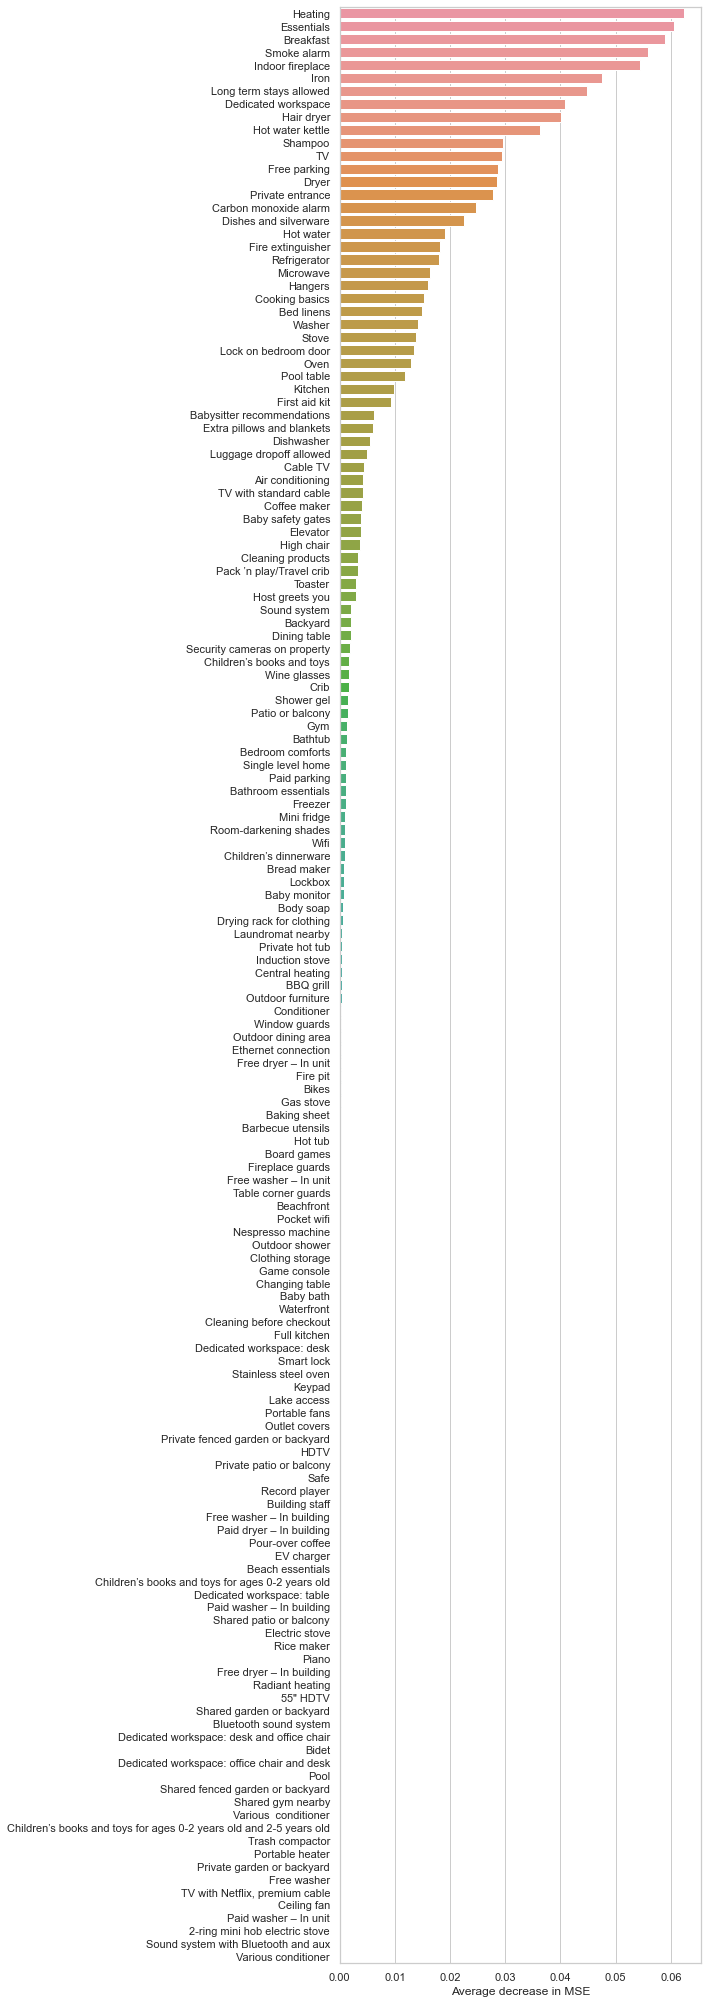

In [255]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation

Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

## Permutation approach

In [256]:
result = permutation_importance(forest, X_test, y_test, n_repeats=50, random_state=42)

forest_importances = pd.Series(result.importances_mean, index=am_df.columns)


KeyboardInterrupt: 

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_91694/1823862734.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


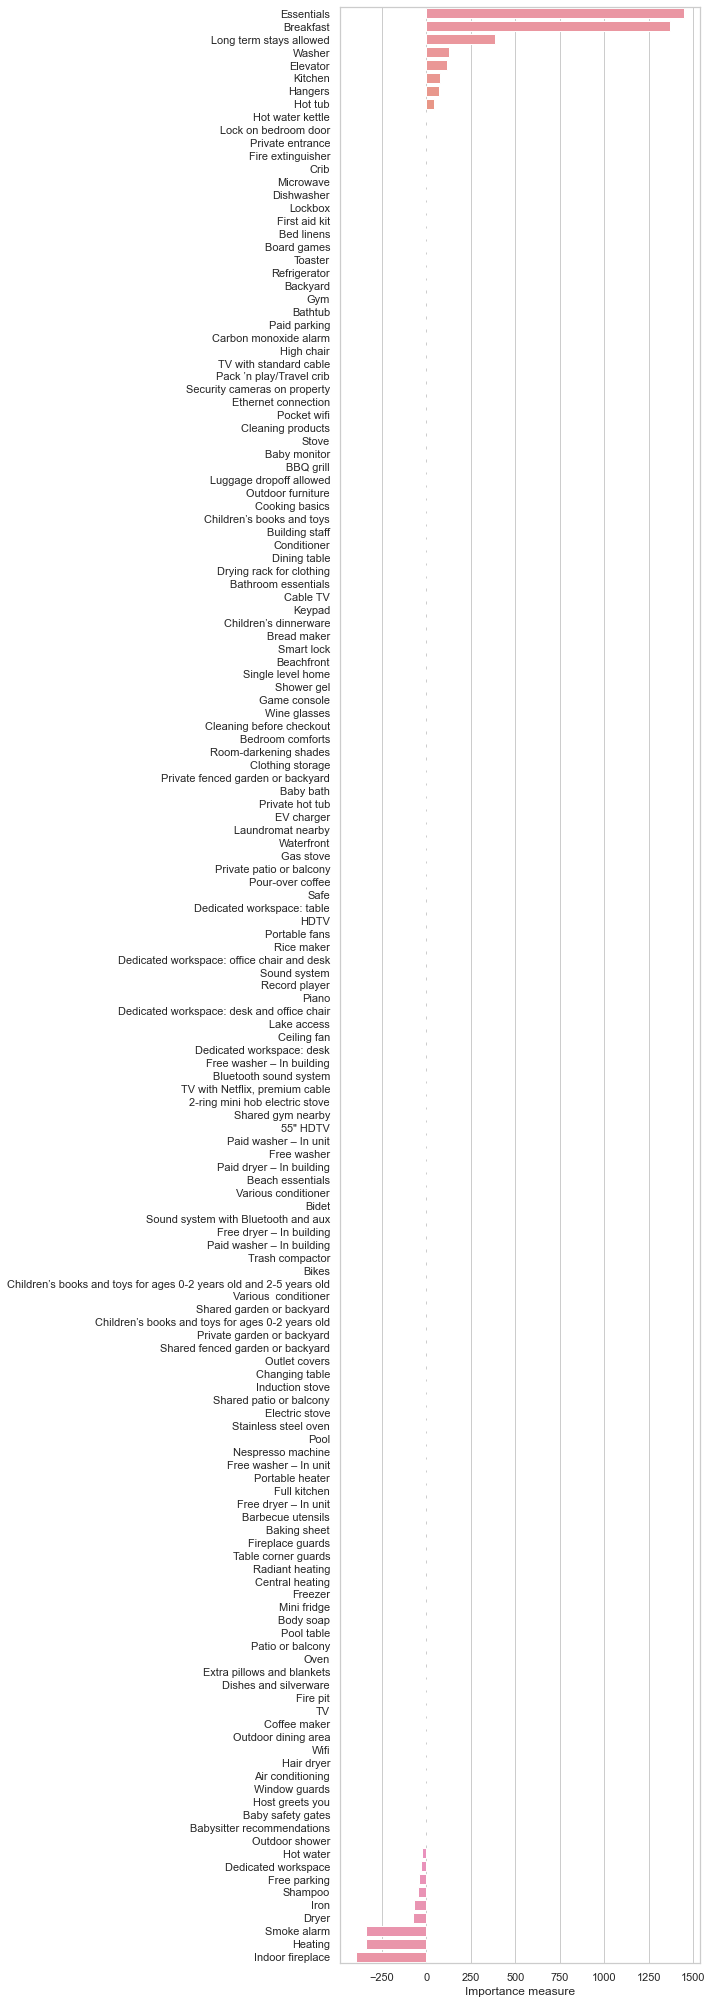

In [ ]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

We observe that indoor fireplace, smoke alarm, heating, dryer, Iron are not as important as indicate by the first approach. The problem of this method is that the importance of highly correlated amenities disappears as shuffling the first feature the model could still get the information by the second correlated feature. 
This can be the case for our data. For instance the possibility to stay for a longer time might be highly correlated with the availability of a washing machine or kitchen and an oven.

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

# Final variable choice

Essentials, long_term_stays, Breakfast, Washer, Kitchen, Hangers, Hottub

In [262]:
final_am = ["Essentials", "Long term stays allowed", "Breakfast", "Washer", "Kitchen", "Hangers", "Hot tub"]
final = am_df[final_am]
final.to_csv("amenities.csv")

In [263]:
final

,Essentials,Long term stays allowed,Breakfast,Washer,Kitchen,Hangers,Hot tub
0,1,1,1,0,0,1,0
1,1,0,1,1,1,1,0
2,1,0,1,1,1,1,0
3,1,0,1,0,0,1,0
4,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...
6971,1,1,0,1,1,1,0
6972,0,1,0,1,1,0,1
6973,1,1,0,1,1,1,0
6974,1,1,0,1,1,1,0
